In [1]:
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm
import glob
import os
from pathlib import Path
import json
import random

In [5]:
ORI_DIR = 'face_data\\original_sequences\\youtube\\c23\\videos'
FAKE_DIR = [
    'face_data\\manipulated_sequences\\Deepfakes\\c23\\videos',
    'face_data\\manipulated_sequences\\FaceSwap\\c23\\videos',
    'face_data\\manipulated_sequences\\NeuralTextures\\c23\\videos',
]

In [6]:
video_paths = [os.path.join(ORI_DIR,x) for x in os.listdir(ORI_DIR)]

In [35]:
nt_paths = [os.path.join(FAKE_DIR[2],x) for x in os.listdir(FAKE_DIR[2])]
nt_paths[:5]

['face_data\\manipulated_sequences\\NeuralTextures\\c23\\videos\\000_003.mp4',
 'face_data\\manipulated_sequences\\NeuralTextures\\c23\\videos\\001_870.mp4',
 'face_data\\manipulated_sequences\\NeuralTextures\\c23\\videos\\002_006.mp4',
 'face_data\\manipulated_sequences\\NeuralTextures\\c23\\videos\\003_000.mp4',
 'face_data\\manipulated_sequences\\NeuralTextures\\c23\\videos\\004_982.mp4']

In [36]:
dpf = {}
for ori in tqdm(video_paths):
    ori_name = Path(ori).name.split('.')[0]
    for fake in nt_paths:
        fake_name = Path(fake).name.split('.')[0].split('_')[0]
        if(ori_name == fake_name):
            dpf[ori] = fake

100%|██████████| 1000/1000 [00:09<00:00, 101.11it/s]


In [39]:
for k,v in dpf.items():
    df.loc[df['ori_path'] == k, 'neural_textures_path'] = v

In [40]:
df.head()

,ori_path,deepfake_path,faceswap_path,neural_textures_path
0,face_data\original_sequences\youtube\c23\video...,face_data\manipulated_sequences\Deepfakes\c23\...,face_data\manipulated_sequences\FaceSwap\c23\v...,face_data\manipulated_sequences\NeuralTextures...
1,face_data\original_sequences\youtube\c23\video...,face_data\manipulated_sequences\Deepfakes\c23\...,face_data\manipulated_sequences\FaceSwap\c23\v...,face_data\manipulated_sequences\NeuralTextures...
2,face_data\original_sequences\youtube\c23\video...,face_data\manipulated_sequences\Deepfakes\c23\...,face_data\manipulated_sequences\FaceSwap\c23\v...,face_data\manipulated_sequences\NeuralTextures...
3,face_data\original_sequences\youtube\c23\video...,face_data\manipulated_sequences\Deepfakes\c23\...,face_data\manipulated_sequences\FaceSwap\c23\v...,face_data\manipulated_sequences\NeuralTextures...
4,face_data\original_sequences\youtube\c23\video...,face_data\manipulated_sequences\Deepfakes\c23\...,face_data\manipulated_sequences\FaceSwap\c23\v...,face_data\manipulated_sequences\NeuralTextures...


In [20]:
paths = []

for _, row in tqdm(df.iterrows()):
    ori_path = row['ori_path']
    ori_name = 'ori_' + Path(ori_path).name.split('.')[0]
    imgs = os.listdir(os.path.join('face_data','face_crops',ori_name))
    
    for f in imgs:
        if f.endswith('txt'):
            continue
        label = 0
        fold = row['fold']
        video = ori_name
        ori_vid = ori_name
        paths.append([video, f, label, ori_vid, int(f.split("_")[0]), fold])
   

    deepfake_path = row['deepfake_path']
    deepfake_name = 'deepfake_' + Path(deepfake_path).name.split('.')[0]
    imgs = os.listdir(os.path.join('face_data','face_crops',deepfake_name))
    for f in imgs:
        if f.endswith('txt'):
            continue
        label = 1
        fold = row['fold']
        video = deepfake_name
        ori_vid = ori_name
        paths.append([video, f, label, ori_vid, int(f.split("_")[0]), fold])

    faceswap_path = row['faceswap_path']
    faceswap_name = 'faceswap_' + Path(faceswap_path).name.split('.')[0]
    imgs = os.listdir(os.path.join('face_data','face_crops',faceswap_name))
    for f in imgs:
        if f.endswith('txt'):
            continue
        label = 1
        fold = row['fold']
        video = faceswap_name
        ori_vid = ori_name
        paths.append([video, f, label, ori_vid, int(f.split("_")[0]), fold])

    nt_path = row['neural_textures_path']
    nt_name = 'nt_' + Path(nt_path).name.split('.')[0]
    imgs = os.listdir(os.path.join('face_data','face_crops',nt_name))
    for f in imgs:
        if f.endswith('txt'):
            continue
        label = 1
        fold = row['fold']
        video = nt_name
        ori_vid = ori_name
        paths.append([video, f, label, ori_vid, int(f.split("_")[0]), fold])
    

1000it [00:03, 282.83it/s]


In [24]:
random.shuffle(paths)
pd.DataFrame(paths, columns=["video", "file", "label", "original", "frame", "fold"]).to_csv('folds.csv', index=False)

In [62]:
labels_df = pd.DataFrame(labels.items(), columns=['path','label'])
labels_df.head()

,path,label
0,face_data\original_sequences\youtube\c23\video...,0
1,face_data\manipulated_sequences\Deepfakes\c23\...,1
2,face_data\manipulated_sequences\FaceSwap\c23\v...,1
3,face_data\manipulated_sequences\NeuralTextures...,1
4,face_data\original_sequences\youtube\c23\video...,0


In [3]:
with open("meta.json", "r") as read_file:
    data = json.load(read_file)
data[0]

{'name': 'ori_000',
 'vid_path': 'face_data\\original_sequences\\youtube\\c23\\videos\\000.mp4',
 'bbox_path': 'face_data\\boxes\\000.json'}

In [8]:
from sklearn import model_selection

df = pd.read_csv('metadata.csv').sample(frac=1).reset_index(drop=True)
df['fold'] = -1
kf = model_selection.KFold(n_splits=10)

for f, (t_, v_) in enumerate(kf.split(X=df)):
    df.loc[v_, 'fold'] = f

In [4]:
df = pd.read_csv('folds.csv')
df.groupby('fold').label.value_counts()

fold  label
0     1        14820
      0         5718
1     1        15131
      0         5911
2     1        14372
      0         5564
3     1        14598
      0         5588
4     1        14069
      0         5269
5     1        15033
      0         5771
6     1        14590
      0         5704
7     1        13785
      0         5275
8     1        13997
      0         5423
9     1        15117
      0         5991
Name: label, dtype: int64

In [10]:
rows = df[~df['fold'].isin([0,1])]
rows.groupby('fold').label.value_counts()

fold  label
2     1        14372
      0         5564
3     1        14598
      0         5588
4     1        14069
      0         5269
5     1        15033
      0         5771
6     1        14590
      0         5704
7     1        13785
      0         5275
8     1        13997
      0         5423
9     1        15117
      0         5991
Name: label, dtype: int64

In [1]:
from dataset import FFPP_Dataset
import cv2
import matplotlib.pyplot as plt

train_data = FFPP_Dataset('ff_data', hardcore = True, oversample_real=True)
train_data.reset(777)

real 50496 fakes 50496 mode train


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


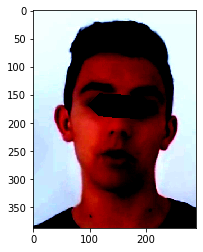

In [15]:
item = train_data[720]
plt.imshow(item['image'].permute(1, 2, 0))
plt.show()

In [4]:
import dlib 
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor('libs/shape_predictor_68_face_landmarks.dat')

In [15]:
img = cv2.imread('ff_data/face_crops/nt_387_311/90_0.png')
rect = detector(img)
print(rect)

rectangles[[(42, 113) (257, 328)]]


In [18]:
import timm

model = timm.create_model('xception', pretrained=True, num_classes=1)

In [24]:
from torchsummary import summary
import torch
inp = torch.rand((1,3,224,224)).cuda()

In [11]:
a = np.array([0.11,0.05,0.87,0.99,0.001,0.25])
a_reshaped = a.reshape(-1, 1)
np.clip(np.concatenate((1.0 - a_reshaped, a_reshaped), axis=1), 0.0, 1.0)

array([[0.89 , 0.11 ],
       [0.95 , 0.05 ],
       [0.13 , 0.87 ],
       [0.01 , 0.99 ],
       [0.999, 0.001],
       [0.75 , 0.25 ]])